In [1]:
import tensorflow as tf

print(tf.__version__)

2.5.0


In [2]:
# 학습과 test할 데이터셋을 준비
import zipfile

!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
zip_ref = zipfile.ZipFile("10_food_classes_10_percent.zip", "r")
zip_ref.extractall()
zip_ref.close()

In [3]:
# 데이터 분석전에 데이터를 살펴보는 것이 우선 작업!
import os

for dirpath, dirnames, filenames in os.walk("10_food_classes_10_percent"):
    print(f"{len(dirnames)}개의 디렉토리와 {len(filenames)}개의 파일이 존재 in {dirpath}")

2개의 디렉토리와 0개의 파일이 존재 in 10_food_classes_10_percent
10개의 디렉토리와 0개의 파일이 존재 in 10_food_classes_10_percent/train
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/ice_cream
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/steak
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/grilled_salmon
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/chicken_curry
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/ramen
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/pizza
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/hamburger
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/fried_rice
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/chicken_wings
0개의 디렉토리와 75개의 파일이 존재 in 10_food_classes_10_percent/train/sushi
10개의 디렉토리와 0개의 파일이 존재 in 10_food_classes_10_percent/test
0개의 디렉토리와 250개의 파일이 존재 in 10_food_classes_10_percent/test/ice_cream
0개의 디렉토리와 250개의 파일이 존재 in 10_food_classes_10_percent/test/steak
0개의 디렉토리와 250개의 파일이 존재 i

In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMAGE_SHAPE = (224, 224)
BATCH_SIZE = 32

train_dir = "10_food_classes_10_percent/train/"
test_dir = "10_food_classes_10_percent/test/"

train_datagen = ImageDataGenerator(rescale = 1/255.) # 일반적인 RGB이미지에서 색이 가질 수 숫자의 범위는 0 ~ 255 => 0 ~ 1 값을 가지도록 normalization
test_datagen = ImageDataGenerator(rescale = 1/255.)

print("Training Image:")
train_data_10_percent = train_datagen.flow_from_directory(
    train_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)

print("Testing Image:")
test_data_10_percent = test_datagen.flow_from_directory(
    test_dir,
    target_size = IMAGE_SHAPE,
    batch_size = BATCH_SIZE,
    class_mode = "categorical"
)

Training Image:
Found 750 images belonging to 10 classes.
Testing Image:
Found 2500 images belonging to 10 classes.


In [5]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
    log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = log_dir)
    print(f"TensorBoard 로그 파일은 {log_dir}에 저장")
    return tensorboard_callback

In [6]:
!pip install tensorflow_hub

In [7]:
# EfficientNetB0 (https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1)
# ResNetV250 (https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4)
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras import layers

In [8]:
resnet_url = "https://tfhub.dev/google/imagenet/resnet_v2_50/feature_vector/4"
efficientnet_url = "https://tfhub.dev/tensorflow/efficientnet/b0/feature-vector/1"

In [9]:
def create_model(model_url, num_classes = 10):
    feature_extractor_layer = hub.KerasLayer(
        model_url,
        trainable=False,
        name = "feature_extraction_layer",
        input_shape = IMAGE_SHAPE + (3, )
    )

    # keras에서는 모델을 만드는 방법이 3가지가 존재 : 1) Sequential 2) functional 3) subclass
    model = tf.keras.Sequential([
        feature_extractor_layer,
        layers.Dense(num_classes, activation = "softmax", name = "output_layer")
    ])

    return model

In [10]:
# Keras에서 학습 시키는 과정
# 1) 모델을 설계 및 생성
resnet_model = create_model(resnet_url, num_classes=train_data_10_percent.num_classes)

In [11]:
# 2) compile (생성한 모델에 설정을 하는 과정)
resnet_model.compile(
    loss = "categorical_crossentropy",
    optimizer = tf.keras.optimizers.Adam(),
    metrics = "accuracy"
)

In [12]:
!pip install pillow
!pip install scipy

In [13]:
# 3) fit (학습)
resnet_history = resnet_model.fit(
    train_data_10_percent,
    epochs = 5,
    steps_per_epoch = len(train_data_10_percent),
    validation_data = test_data_10_percent,
    validation_steps = len(test_data_10_percent),
    callbacks = [
        create_tensorboard_callback(
            dir_name = "tensorflow_hub",
            experiment_name = "resnet50V2"
        )
    ]
)

TensorBoard 로그 파일은 tensorflow_hub/resnet50V2/20210729-144430에 저장
Epoch 1/5
24/24 [==============================] - 20s 543ms/step - loss: 2.1038 - accuracy: 0.2840 - val_loss: 1.2995 - val_accuracy: 0.5764
Epoch 2/5
24/24 [==============================] - 10s 423ms/step - loss: 0.9600 - accuracy: 0.7173 - val_loss: 0.9015 - val_accuracy: 0.7064
Epoch 3/5
24/24 [==============================] - 10s 430ms/step - loss: 0.6410 - accuracy: 0.8213 - val_loss: 0.7782 - val_accuracy: 0.7516
Epoch 4/5
24/24 [==============================] - 10s 430ms/step - loss: 0.4983 - accuracy: 0.8667 - val_loss: 0.7164 - val_accuracy: 0.7724
Epoch 5/5
24/24 [==============================] - 10s 426ms/step - loss: 0.3897 - accuracy: 0.9067 - val_loss: 0.6917 - val_accuracy: 0.7796


In [14]:
!pip install matplotlib

In [15]:
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

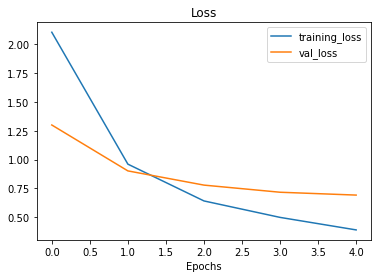

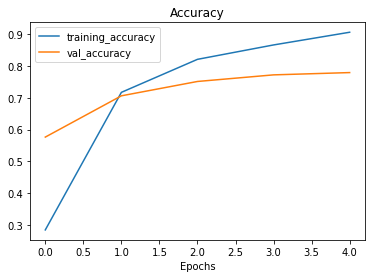

In [16]:
plot_loss_curves(resnet_history)

In [17]:
# efficientnet_model을 생성 후 학습을 해보세요
efficientnet_model = create_model(
    model_url=efficientnet_url,
    num_classes=train_data_10_percent.num_classes
)

In [18]:
efficientnet_model.compile(
    loss="categorical_crossentropy",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [19]:
efficientnet_history = efficientnet_model.fit(
    train_data_10_percent,
    epochs=5,
    steps_per_epoch=len(train_data_10_percent),
    validation_data=test_data_10_percent,
    validation_steps=len(test_data_10_percent),
    callbacks=[
        create_tensorboard_callback(
            dir_name="tensorflow_hub", 
            experiment_name="efficientnetb0")
    ]
)

TensorBoard 로그 파일은 tensorflow_hub/efficientnetb0/20210729-144542에 저장
Epoch 1/5
24/24 [==============================] - 21s 557ms/step - loss: 1.8648 - accuracy: 0.4400 - val_loss: 1.3094 - val_accuracy: 0.7144
Epoch 2/5
24/24 [==============================] - 10s 415ms/step - loss: 1.0770 - accuracy: 0.7520 - val_loss: 0.8808 - val_accuracy: 0.8080
Epoch 3/5
24/24 [==============================] - 10s 414ms/step - loss: 0.7679 - accuracy: 0.8307 - val_loss: 0.7107 - val_accuracy: 0.8340
Epoch 4/5
24/24 [==============================] - 11s 460ms/step - loss: 0.6155 - accuracy: 0.8507 - val_loss: 0.6229 - val_accuracy: 0.8476
Epoch 5/5
24/24 [==============================] - 11s 469ms/step - loss: 0.5208 - accuracy: 0.8800 - val_loss: 0.5676 - val_accuracy: 0.8584


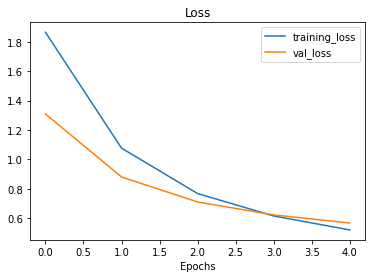

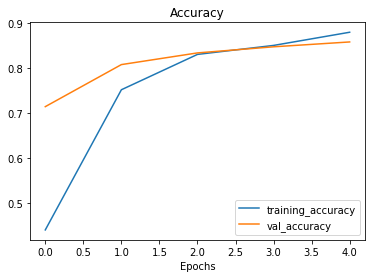

In [20]:
plot_loss_curves(efficientnet_history)

In [21]:
efficientnet_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 1280)              4049564   
_________________________________________________________________
output_layer (Dense)         (None, 10)                12810     
Total params: 4,062,374
Trainable params: 12,810
Non-trainable params: 4,049,564
_________________________________________________________________


In [22]:
resnet_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
feature_extraction_layer (Ke (None, 2048)              23564800  
_________________________________________________________________
output_layer (Dense)         (None, 10)                20490     
Total params: 23,585,290
Trainable params: 20,490
Non-trainable params: 23,564,800
_________________________________________________________________


In [23]:
len(efficientnet_model.layers[0].weights)

309

In [24]:
len(resnet_model.layers[0].weights)

270

In [25]:
# 결과 업로드
# !tensorboard dev upload --logdir ./tensorflow_hub/ --name "1일차" --description "전체 학습 데이터셋의 10%로 TF Hub feature extraction model 구조 비교" --one_shot

# 결과 지우기
# !tensorboard dev delete --experiment_id <your_tb_experiment_id>

In [26]:
!tensorboard dev list

2021-07-29 14:47:58.885110: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Data for the "text" plugin is now uploaded to TensorBoard.dev! Note that uploaded data is public. If you do not want to upload data for this plugin, use the "--plugins" command line argument.
https://tensorboard.dev/experiment/9O3yvsmOTViwpumFqKksbQ/
	Name                 1일차
	Description          전체 학습 데이터셋의 10%로 TF Hub feature extraction model 구조 비교
	Id                   9O3yvsmOTViwpumFqKksbQ
	Created              2021-07-29 14:13:05 (35 minutes ago)
	Updated              2021-07-29 14:13:20 (34 minutes ago)
	Runs                 4
	Tags                 5
	Scalars              54
	Tensor bytes         0
	Binary object bytes  3809336
Total: 1 experiment(s)


In [27]:
def load_and_prep_image(filename, img_shape=224):
    img = tf.io.read_file(filename)
    img = tf.image.decode_image(img)
    img = tf.image.resize(img, size=[img_shape, img_shape])
    img = img/255.
    return img

In [28]:
import pathlib
import numpy as np

data_dir = pathlib.Path("10_food_classes_10_percent/train")
class_names = np.array(sorted([item.name for item in data_dir.glob("*")])) # Created a list of class_names from the subdirectories
print(class_names)

['chicken_curry' 'chicken_wings' 'fried_rice' 'grilled_salmon' 'hamburger'
 'ice_cream' 'pizza' 'ramen' 'steak' 'sushi']


In [29]:
def pred_and_plot(model, filename, class_names=class_names):
    img = load_and_prep_image(filename)
    
    pred = model.predict(tf.expand_dims(img, axis=0))
    
    if len(pred[0]) > 1:
        pred_class = class_names[tf.argmax(pred[0])]
    else:
        pred_class = class_names[int(tf.round(pred[0]))]
    
    plt.imshow(img)
    plt.title(f"Prediction: {pred_class}")
    plt.axis(False);

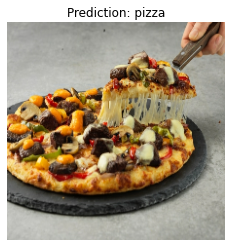

In [31]:
pred_and_plot(
    model=efficientnet_model,
    filename="test_pizza.jpg",
    class_names=class_names
)

In [32]:
efficientnet_model.save("my_model")

INFO:tensorflow:Assets written to: my_model/assets


INFO:tensorflow:Assets written to: my_model/assets
